In [1]:
from random import gauss
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from arch.univariate import arch_model
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import warnings
warnings.filterwarnings("ignore")

# GARCH(2,2) Model

$$a_t = \varepsilon_t \sigma_t $$
$$\sigma_t^2 = \omega + \alpha_1 a_{t-1}^2 + \alpha_2 a_{t-2}^2 + \beta_1 \sigma_{t-1}^2 + \beta_2 \sigma_{t-2}^2 $$

$$
a_0, a_1 \sim \mathcal{N}(0,1)
$$

$$
\sigma_0 =1, \sigma_1 = 1
$$

$$
\varepsilon_t \sim \mathcal{N}(0,1)
$$

## Simulate the time series

In [2]:
# create dataset
n = 1000
omega = 0.5

alpha_1 = 0.1
alpha_2 = 0.2

beta_1 = 0.3
beta_2 = 0.4

test_size = int(n*0.1)

series = [gauss(0,1), gauss(0,1)]
vols = [1, 1]

for _ in range(n):
    new_vol = np.sqrt(omega + alpha_1*series[-1]**2 + alpha_2*series[-2]**2 + beta_1*vols[-1]**2 + beta_2*vols[-2]**2)
    new_val = gauss(0,1) * new_vol
    
    vols.append(new_vol)
    series.append(new_val)

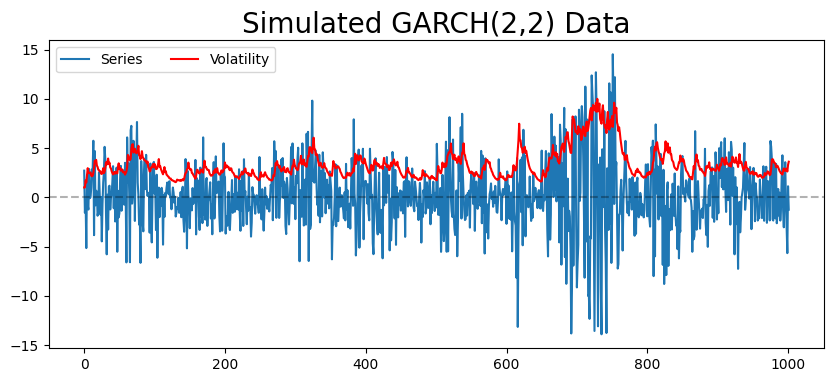

In [3]:
plt.figure(figsize=(10,4))
plt.plot(series, label='Series')
plt.plot(vols, color='red', label='Volatility')
plt.axhline(0, ls='--', alpha=0.3, color='k')
plt.legend(ncol=2, loc='best')
plt.title('Simulated GARCH(2,2) Data', fontsize=20)
plt.show()

## PACF Plot

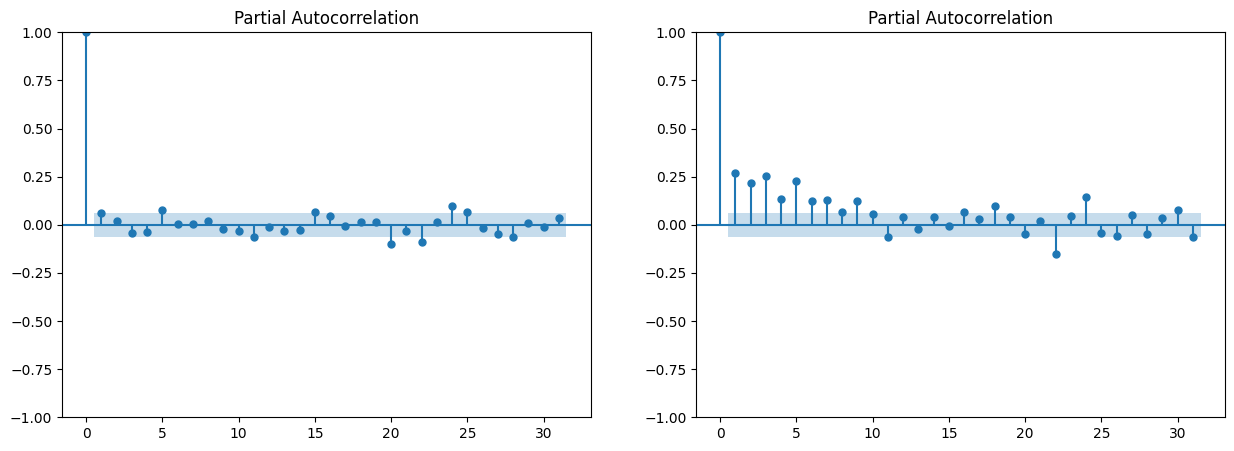

In [4]:
f, axes = plt.subplots(1,2,figsize=(15,5))
plot_pacf(np.array(series), ax=axes[0])
plot_pacf(np.array(series)**2, ax=axes[1])
plt.show()

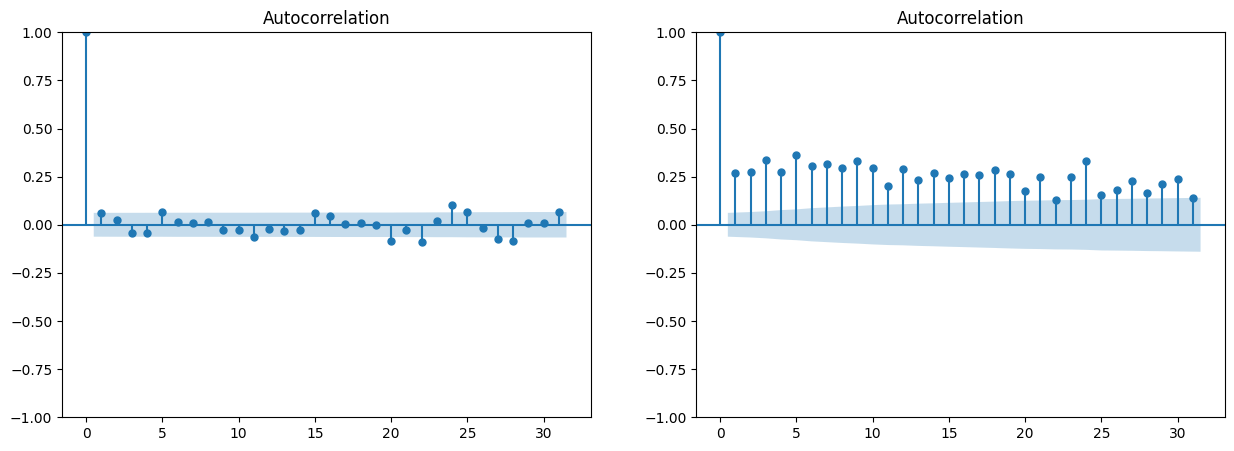

In [5]:
f, axes = plt.subplots(1,2,figsize=(15,5))
plot_acf(np.array(series), ax=axes[0])
plot_acf(np.array(series)**2, ax=axes[1])
plt.show()

ARCH effect:
* No autocorrelation between $a_t$ and $a_{t-k}$ $\forall k>0$ 
* Auto-correlation of squared returns 

# Fit the GARCH Model

In [6]:
train, test = series[:-test_size], series[-test_size:]

In [7]:
model = arch_model(train, mean='Zero', p=2, o=0, q=2)

In [8]:
model_fit = model.fit(disp='off')
constant_params = model_fit.params
print(model_fit.summary())

                       Zero Mean - GARCH Model Results                        
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                      GARCH   Log-Likelihood:               -2263.22
Distribution:                  Normal   AIC:                           4536.43
Method:            Maximum Likelihood   BIC:                           4560.46
                                        No. Observations:                  902
Date:                Fri, Apr 14 2023   Df Residuals:                      902
Time:                        08:17:45   Df Model:                            0
                              Volatility Model                             
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          0.6886      0.280      2.455  1.408e-02    [  

## Predict

In [9]:
predictions = model_fit.forecast(horizon=test_size)

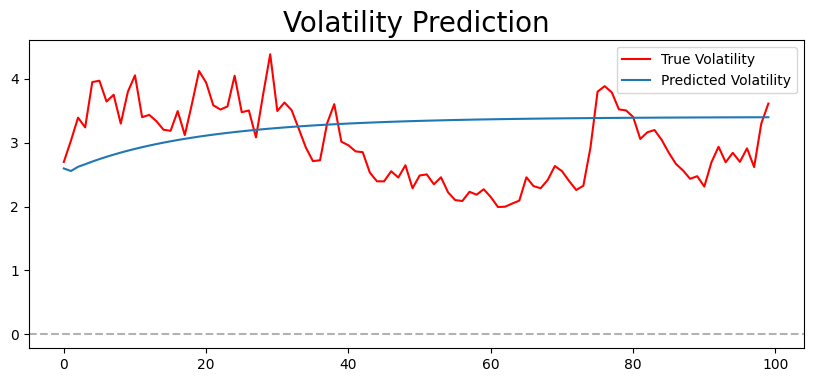

In [16]:
plt.figure(figsize=(10,4))
#true, = plt.plot(series[-test_size:], label='True Series')
true, = plt.plot(vols[-test_size:], label='True Volatility', color='red')
preds, = plt.plot(np.sqrt(predictions.variance.values[-1, :]), label='Predicted Volatility')
plt.axhline(0, ls='--', alpha=0.3, color='k')
plt.legend(loc='best')
plt.title('Volatility Prediction', fontsize=20)
plt.show()

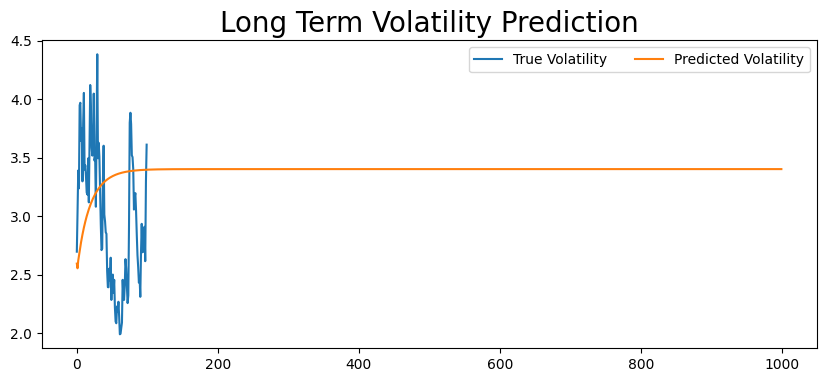

In [11]:
predictions_long_term = model_fit.forecast(horizon=1000)
plt.figure(figsize=(10,4))
true, = plt.plot(vols[-test_size:], label='True Volatility')
preds, = plt.plot(np.sqrt(predictions_long_term.variance.values[-1, :]), label='Predicted Volatility')
plt.legend(ncol=2)
plt.title('Long Term Volatility Prediction', fontsize=20)
plt.show()

## Rolling Forecast Origin

In [12]:
rolling_predictions = []
params = {}
for i in range(test_size):
    train = series[:-(test_size-i)]
    model = arch_model(train, mean='Zero', p=2, q=2)
    model_fit = model.fit(disp='off')
    params[i] = model_fit.params
    pred = model_fit.forecast(horizon=1)
    rolling_predictions.append(np.sqrt(pred.variance.values[-1,:][0]))
params = pd.concat(params.values(), keys=params.keys(), axis=1).T

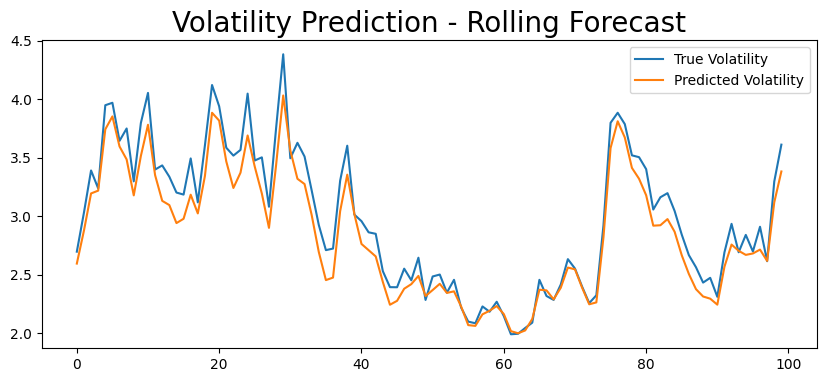

In [13]:
plt.figure(figsize=(10,4))
true, = plt.plot(vols[-test_size:], label = 'True Volatility')
preds, = plt.plot(rolling_predictions, label = 'Predicted Volatility')
plt.legend(loc='best')
plt.title('Volatility Prediction - Rolling Forecast', fontsize=20)
plt.show()

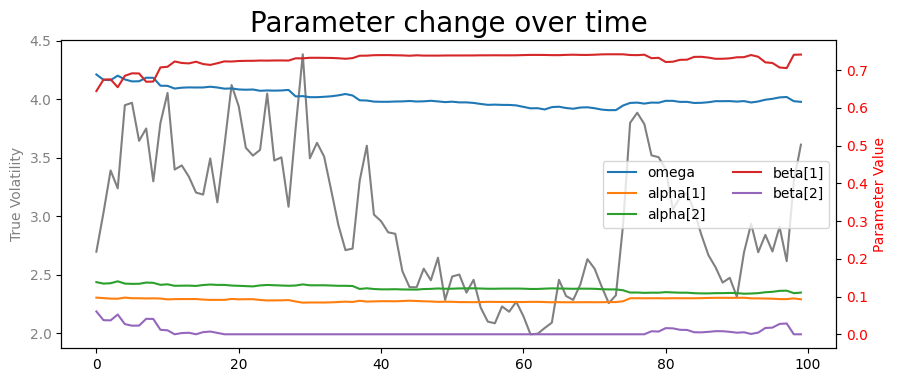

In [15]:
fig, ax1 = plt.subplots(figsize=(10, 4))

# plot the first plot on the left axis
ax1.plot(vols[-test_size:], label='True Volatility', color='grey')
ax1.set_ylabel('True Volatility', color='grey')
ax1.tick_params(axis='y', labelcolor='grey')

# create a twin axis for the second plot on the right
ax2 = ax1.twinx()

# plot the second plot on the right axis
ax2.plot(params)
ax2.set_ylabel('Parameter Value', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# add a title and legend
plt.title('Parameter change over time', fontsize=20)
plt.legend( list(params.columns), ncol=2, loc='best')

plt.show()

## Conclusion

* Note that the GARCH  have no effect on the **conditional mean**, but only on the **conditional volatility**
* The best usage of the Garch model prediction, as any time-series model is to re-estimate the parameters every day and predict **1 step ahead** 
* Parameters update take the recent sudden changes in volatility